In [1]:
# Import libraries

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2.4.0


In [2]:
# Specify paths to the training and validation dataset directories

train_path = 'dataset/train'
#val_path = 'your validation dataset directory'

train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
#val_datagen = ImageDataGenerator(rescale=1/255)



In [3]:
# Generate batches of tensor image data for training

target_size = (224,224)

train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
train_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical')

Found 6141 images belonging to 3 classes.


In [4]:
# Generate batches of tensor image data for validation

val_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')


Found 1226 images belonging to 3 classes.


In [5]:
# Filter warnings

import warnings
warnings.filterwarnings('ignore')

{'COVID-19': 0, 'Normal': 1, 'Pneumonia-Viral': 2}


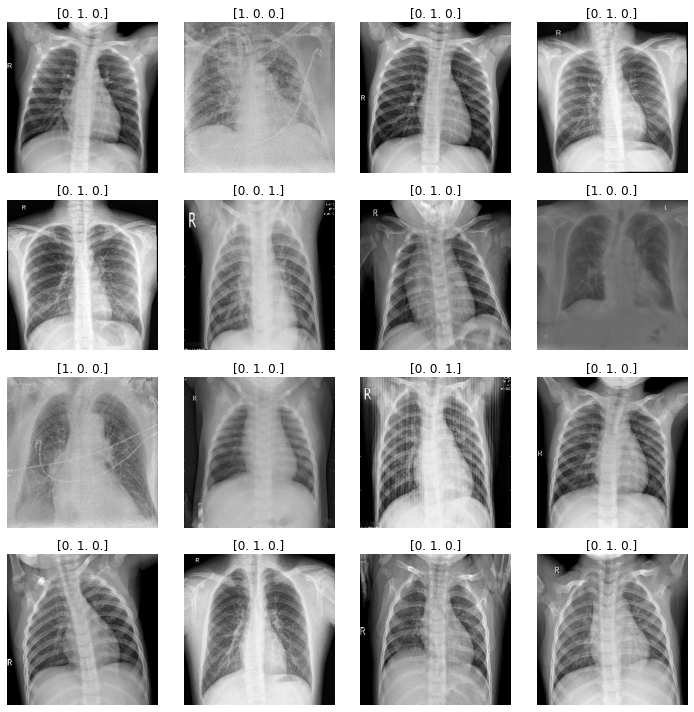

In [6]:
# Visualize samples of training images

class_labels = train_data_gen.class_indices
print(class_labels)

sample_training_images, labels = next(train_data_gen)

def plotImages(images_arr, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.flatten()
    for img, lbs, ax in zip( images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(lbs)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:16], labels[:16])

In [6]:
# Import the Resnet model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [7]:
from keras.layers import Input
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D


In [8]:
# Define your pre-trained model

input_shape = (224,224,3)
pretrained_model = InceptionV3(input_shape = input_shape,
                weights = 'imagenet',
                #layers=tf.keras.layers,
                include_top = False)
pretrained_model.trainable = False

87916544/87910968 [==============================] - 73s 1us/step


In [9]:
# Make all the layers untrainable 

for layer in pretrained_model.layers:
    layer.trainable = False

In [10]:
# Define your model

model = Sequential()

model.add(pretrained_model)

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 153603    
_________________________________________________________________
activation_94 (Activation)   (None, 3)                 0         
Total params: 21,956,387
Trainable params: 153,603
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
# Define early stopping and model checkpoint for optimizing epoch number and saving the best model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
patience=20)

mc = ModelCheckpoint('covid_19_resnet1.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

In [12]:
# Compile and fit your model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
with tf.device('/gpu:0'):
    history = model.fit_generator(train_data_gen,
                              steps_per_epoch=train_data_gen.samples/train_data_gen.batch_size,
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=val_data_gen.samples/val_data_gen.batch_size,
                              callbacks=[es,mc] )

Epoch 1/20
191/191 [==============================] - 163s 797ms/step - loss: 2.4892 - accuracy: 0.8130 - val_loss: 0.2004 - val_accuracy: 0.9608

Epoch 00001: accuracy improved from -inf to 0.89106, saving model to covid_19_resnet1.h5
Epoch 2/20
191/191 [==============================] - 144s 751ms/step - loss: 0.3306 - accuracy: 0.9516 - val_loss: 0.0409 - val_accuracy: 0.9894

Epoch 00002: accuracy improved from 0.89106 to 0.94822, saving model to covid_19_resnet1.h5
Epoch 3/20
191/191 [==============================] - 142s 735ms/step - loss: 0.1919 - accuracy: 0.9661 - val_loss: 0.0316 - val_accuracy: 0.9918

Epoch 00003: accuracy improved from 0.94822 to 0.96108, saving model to covid_19_resnet1.h5
Epoch 4/20
191/191 [==============================] - 143s 742ms/step - loss: 0.4064 - accuracy: 0.9495 - val_loss: 0.0298 - val_accuracy: 0.9959

Epoch 00004: accuracy did not improve from 0.96108
Epoch 5/20
191/191 [==============================] - 143s 745ms/step - loss: 0.1673 - a

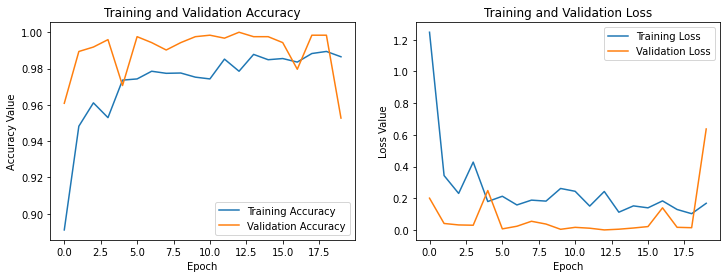

In [13]:
# Plot accuracy and loss for testing and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
# Evaluate your model with confusion matrix and classification report

class_labels = train_data_gen.class_indices
print(class_labels)
print('\n')

from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(val_data_gen, val_data_gen.samples // val_data_gen.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix \n')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('\n')
print('Classification Report \n')
target_names = ['COVID-19', 'Normal','Pneumonia-Viral']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

{'COVID-19': 0, 'Normal': 1, 'Pneumonia-Viral': 2}


Confusion Matrix 

[[199   8  44]
 [  0 643   6]
 [  0   0 326]]


Classification Report 

                 precision    recall  f1-score   support

       COVID-19       1.00      0.79      0.88       251
         Normal       0.99      0.99      0.99       649
Pneumonia-Viral       0.87      1.00      0.93       326

       accuracy                           0.95      1226
      macro avg       0.95      0.93      0.93      1226
   weighted avg       0.96      0.95      0.95      1226

